# Project 2 - Classification and regression using Neural Networks
## Part d) and e)

This notebook contains the code which produces the results for the Project 2 report in FYS-STK4155 regarding activation functions and norms.

*Fall 2025*

**Authors:** Jenny Guldvog, Ingvild Olden Bjerklund, Sverre Manu Johansen & Kjersti Stangeland

### Part d) Testing different activation functions and depths of the neural network

**Task**: You should also test different activation functions for the hidden layers. Try out the Sigmoid, the RELU and the Leaky RELU functions and discuss your results. Test your results as functions of the number of hidden layers and nodes. Do you see signs of overfitting? It is optional in this project to perform a bias-variance trade-off analysis.

In [1]:
import sys, os
import matplotlib.pyplot as plt
import autograd.numpy as np
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from functions import *

%load_ext autoreload
%autoreload 2

# For reproducibility
# Same seed as project 1
np.random.seed(2018)
seed = np.random.seed(2018)

plt.rcParams.update({
    'font.size': 20,          
    'axes.titlesize': 22,     
    'axes.labelsize': 20,   
    'xtick.labelsize': 20,  
    'ytick.labelsize': 20,
    'legend.fontsize': 20,    
    'figure.titlesize': 24,   
})

# For plotting
import matplotlib.style as mplstyle

mplstyle.use(["ggplot", "fast"])

sns.set_context("notebook", font_scale=1.3)
sns.set_style("whitegrid")

# For saving figures
out_dir = Path("../../Figures")
out_dir.mkdir(parents=True, exist_ok=True)

In [2]:
# Same data set as in project 1
n = 1500
x = np.linspace(-1, 1, n)
x = x.reshape(-1, 1)

y = runge_function(x) + np.random.normal(0, 0.1, (n,1))

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

X_mean = X_train.mean(axis=0)
X_train_norm = (X_train - X_mean)
X_test_norm  = (X_test - X_mean)

**To assess how network depth and width influence network performance, we train the network with different number of hidden layers and different number of nodes per layer. In addition to that, we see how different activation functions in the hidden layers impact the performance.**

In the end, we will compare the results to the performance of classical regression methods as done in project 1. Therefore, we will use some of the same parameter setup as in project 1, for comparison. That is, a batch sizes of 20, 300 epochs and a learning rate of 0.01. This is the same setup we did for stochastic gradient descent methods in project 1.

In [3]:
layer_options = [1, 2, 3, 4, 5, 6, 7]  # different options for number of hidden layers
node_options = [2, 4, 8, 16, 32, 64, 128]  # different options for number of nodes in each hidden layer
hidden_layers_options = [[n]*l for l in layer_options for n in node_options]
activation_options = [sigmoid, RELU, LRELU]  # different activation functions for hidden layers

batch_size = 20
number_of_epochs = 300
learning_rate = 0.01

**The neural network is trained with the above parameters and the results are stored in a Pandas dataframe. The metric used to assess performance is mean squared error.**

We found in part b and c that the Adam optimizer work the best for our NN with the given parameters. The network below is therefore trained with Adam. 

In [4]:
results = []

for layers in hidden_layers_options:
    for activate in activation_options:

        activation_funcs = [activate]*len(layers) + [identity]  # hidden + output
        activation_ders  = [derivate(activate) for _ in layers] + [derivate(identity)]

        # Initialize network
        nn = NeuralNetwork(
            network_input_size=X_train.shape[1],
            layer_output_sizes=layers + [1],
            activation_funcs=activation_funcs,
            activation_ders=activation_ders,
            cost_fun=mse,
            cost_der=mse_der
        )
        
        # Train network with stochastic gradient descent
        nn.train_SGD(X_train, y_train, epochs=number_of_epochs, learning_rate=learning_rate, batch_size=batch_size, optimizer="Adam")

        y_pred_test = nn._feed_forward(X_test)
        y_pred_train = nn._feed_forward(X_train)
        
        # Compute errors
        train_err = mse(y_pred_train, y_train)
        test_err  = mse(y_pred_test, y_test)
        
        results.append({
            "layers": layers,
            "activation": activate.__name__,
            "y_pred_test": y_pred_test,
            "y_pred_train": y_pred_train,
            "train_error": train_err,
            "test_error": test_err
        })

df = pd.DataFrame(results)

**Plotting the MSE as a function of hidden layers.**

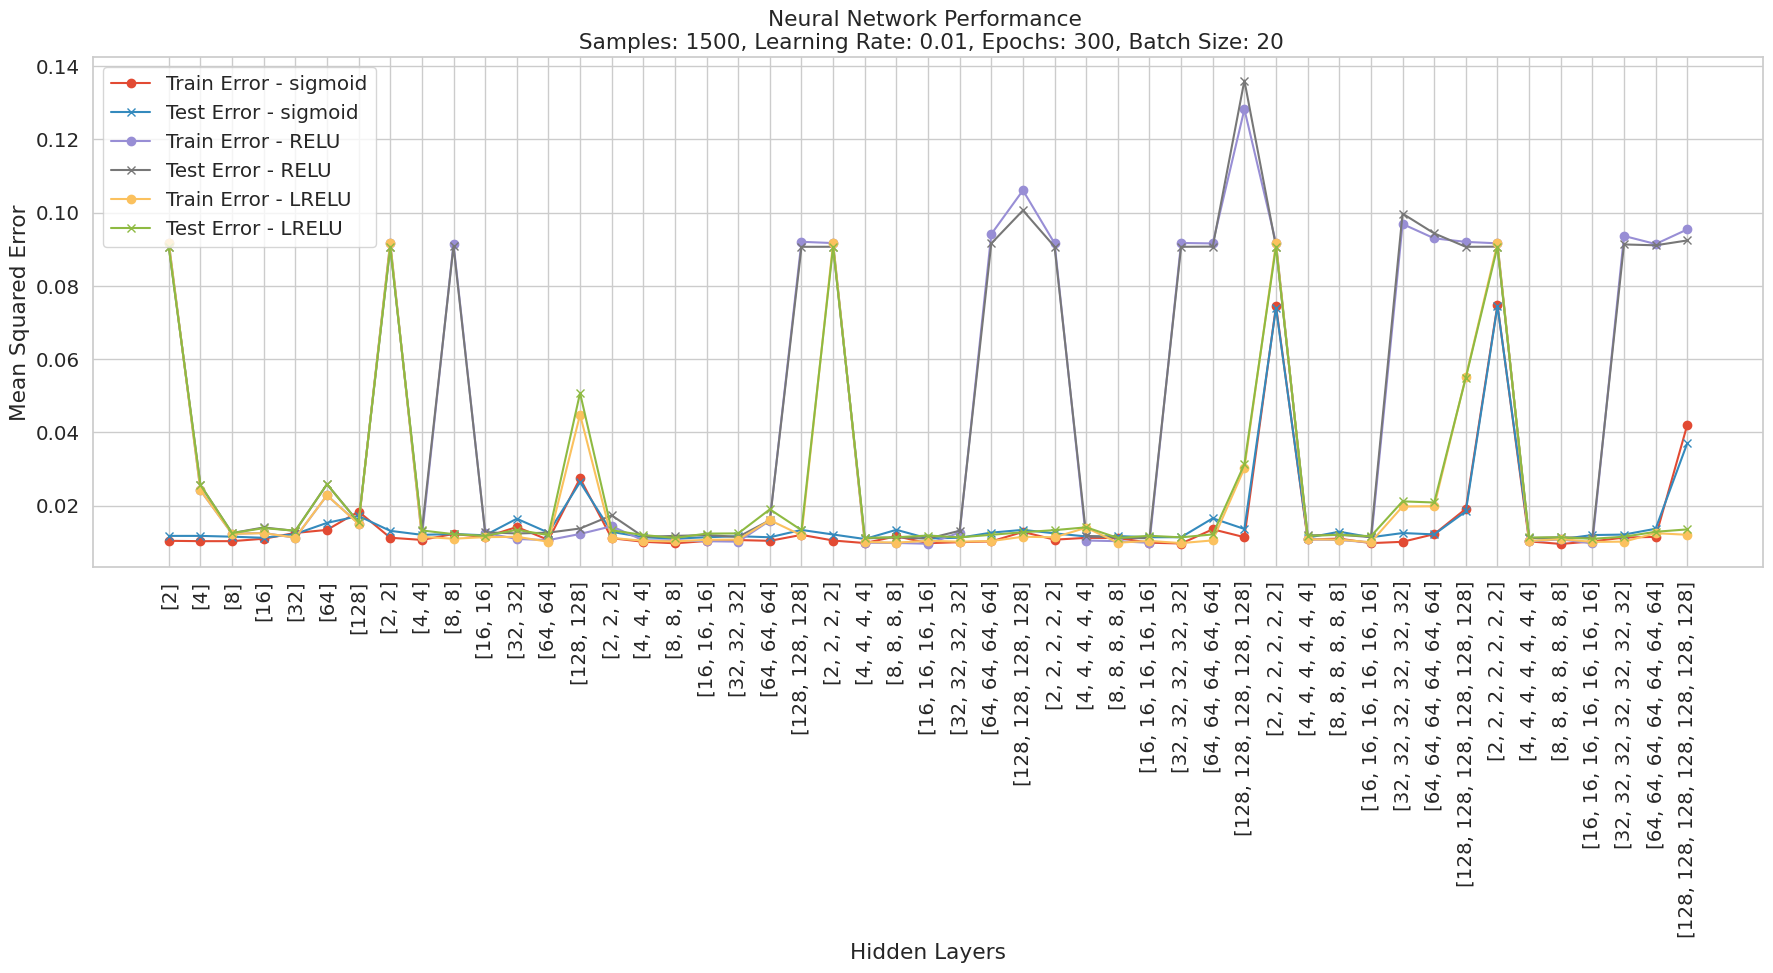

In [5]:
fig, ax = plt.subplots(figsize=(18,10))

for activate in df['activation'].unique():
    subset = df[df['activation'] == activate]
    ax.plot(subset['layers'].astype(str), subset['train_error'], marker='o', label=f'Train Error - {activate}')
    ax.plot(subset['layers'].astype(str), subset['test_error'], marker='x', label=f'Test Error - {activate}')

ax.set_xlabel("Hidden Layers")
ax.set_ylabel("Mean Squared Error")
ax.set_title(f"Neural Network Performance \n Samples: {n}, Learning Rate: {learning_rate}, Epochs: {number_of_epochs}, Batch Size: {batch_size}")
ax.legend()
plt.xticks(rotation=90)
plt.grid(True)
fig.tight_layout()
fig.savefig(out_dir / "d_mse_architectures_lineplot.png")

**We do not see any signs of overfitting in the figure above. The train and test error follow each other for all hidden layer configurations for all activation functions.**

**Now we plot heatmaps to better see the impact on MSE of the number of nodes and number of hidden layers.**

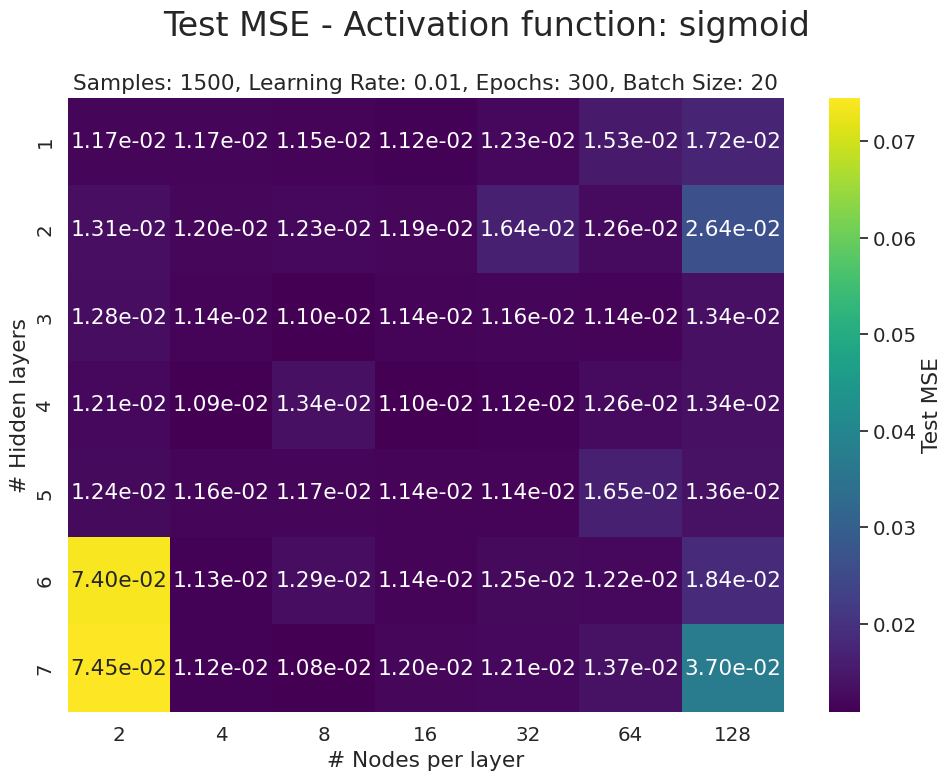

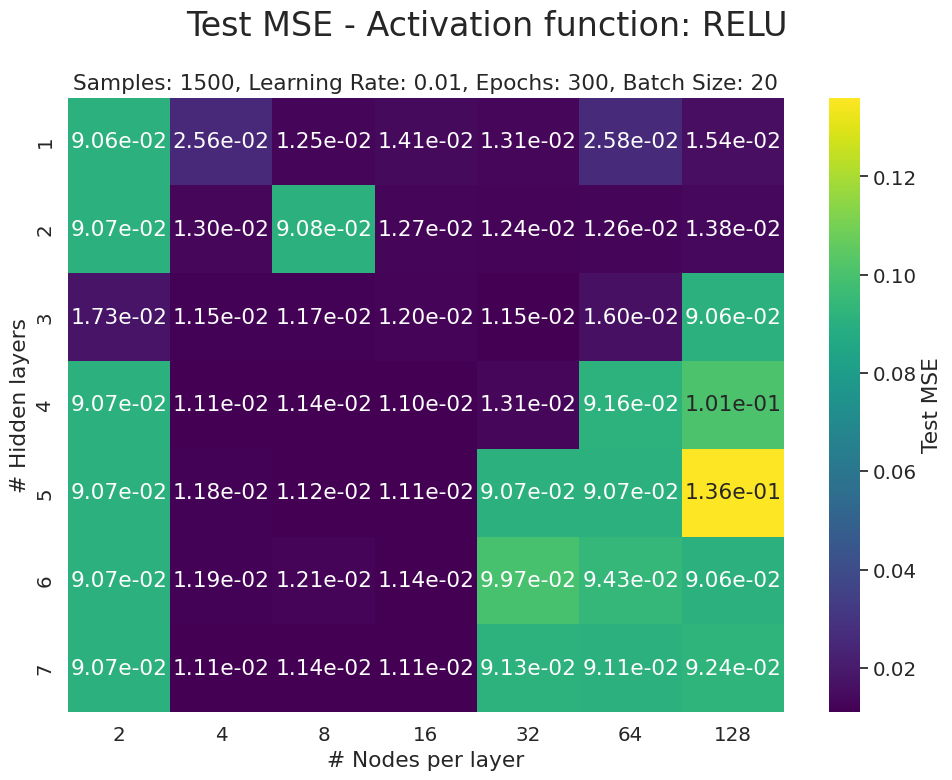

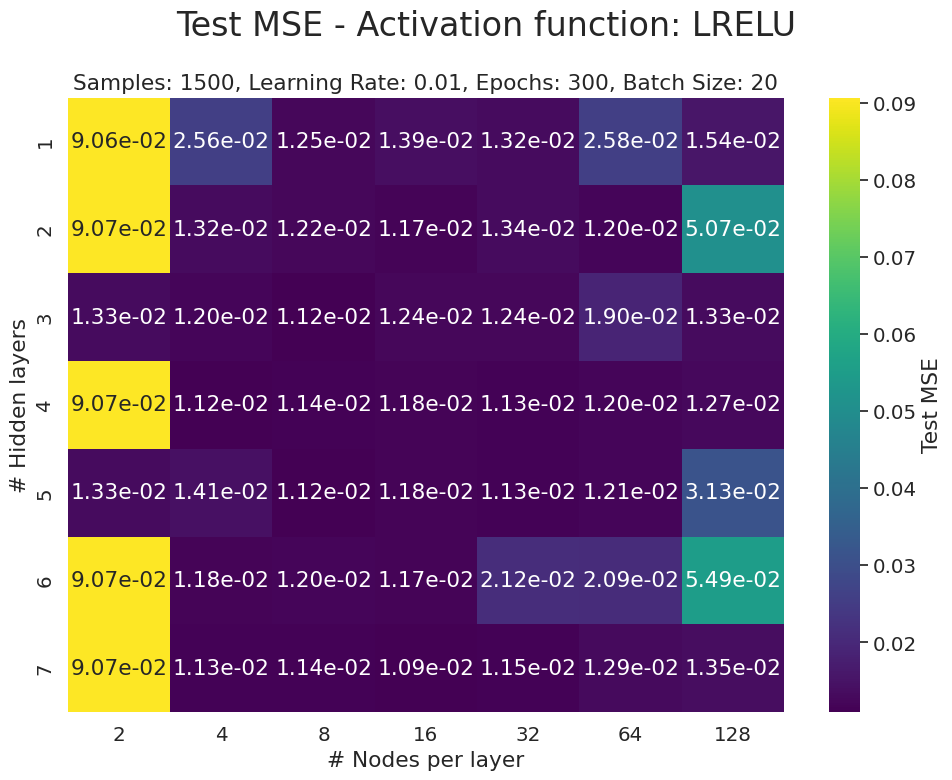

In [6]:
df["n_hidden_layers"] = df["layers"].apply(len)
df["n_nodes"] = df["layers"].apply(lambda x: x[0])

for act in df["activation"].unique():
    df_plot = df[df["activation"] == act]

    fig, ax = plt.subplots(figsize=(10, 8))

    heatmap_test = df_plot.pivot_table(
        index="n_hidden_layers",
        columns="n_nodes",
        values="test_error",
        aggfunc="mean"
    )

    sns.heatmap(
        heatmap_test,
        annot=True,
        fmt=".2e",
        cmap="viridis",
        cbar_kws={"label": "Test MSE"},
        ax=ax
    )
    ax.set_xlabel("# Nodes per layer")
    ax.set_ylabel("# Hidden layers")

    ax.set_title(f"Samples: {n}, Learning Rate: {learning_rate}, Epochs: {number_of_epochs}, Batch Size: {batch_size}")
    fig.suptitle(f"Test MSE - Activation function: {act}")
    plt.tight_layout()

    fig.savefig(out_dir / f"d_NN_mse_{act}.pdf", dpi=200, bbox_inches="tight")


**Finding the architectures with the lowest MSE.**

In [7]:
best_sigmoid_test = df[df["activation"] == "sigmoid"].sort_values("test_error").iloc[0]
best_RELU_test = df[df["activation"] == "RELU"].sort_values("test_error").iloc[0]
best_LRELU_test = df[df["activation"] == "LRELU"].sort_values("test_error").iloc[0]

best_sigmoid_train = df[df["activation"] == "sigmoid"].sort_values("train_error").iloc[0]
best_RELU_train = df[df["activation"] == "RELU"].sort_values("train_error").iloc[0]
best_LRELU_train = df[df["activation"] == "LRELU"].sort_values("train_error").iloc[0]

In [8]:
print("Best NN architectures for different activation functions:")
print("----------------------------------------------------------")
print("Sigmoid, assessed for MSE on the training data:", best_sigmoid_train)
print()
print("RELU, assessed for MSE on the training data:", best_RELU_train)
print()
print("LRELU, assessed for MSE on the training data:", best_LRELU_train)

Best NN architectures for different activation functions:
----------------------------------------------------------
Sigmoid, assessed for MSE on the training data: layers                                         [8, 8, 8, 8, 8, 8, 8]
activation                                                   sigmoid
y_pred_test        [[0.07704310183517182], [0.16736629268436998],...
y_pred_train       [[0.44395218922975765], [0.1320714383119146], ...
train_error                                                 0.009542
test_error                                                  0.010844
n_hidden_layers                                                    7
n_nodes                                                            8
Name: 132, dtype: object

RELU, assessed for MSE on the training data: layers                                              [16, 16, 16, 16]
activation                                                      RELU
y_pred_test        [[0.06006480119340131], [0.1625313972603597], ...
y_pre

In [9]:
print("Best NN architectures for different activation functions:")
print("----------------------------------------------------------")
print("Sigmoid, assessed for MSE on the test data:", best_sigmoid_test)
print()
print("RELU, assessed for MSE on the test data:", best_RELU_test)
print()
print("LRELU, assessed for MSE on the test data:", best_LRELU_test)

Best NN architectures for different activation functions:
----------------------------------------------------------
Sigmoid, assessed for MSE on the test data: layers                                         [8, 8, 8, 8, 8, 8, 8]
activation                                                   sigmoid
y_pred_test        [[0.07704310183517182], [0.16736629268436998],...
y_pred_train       [[0.44395218922975765], [0.1320714383119146], ...
train_error                                                 0.009542
test_error                                                  0.010844
n_hidden_layers                                                    7
n_nodes                                                            8
Name: 132, dtype: object

RELU, assessed for MSE on the test data: layers                                              [16, 16, 16, 16]
activation                                                      RELU
y_pred_test        [[0.06006480119340131], [0.1625313972603597], ...
y_pred_train 

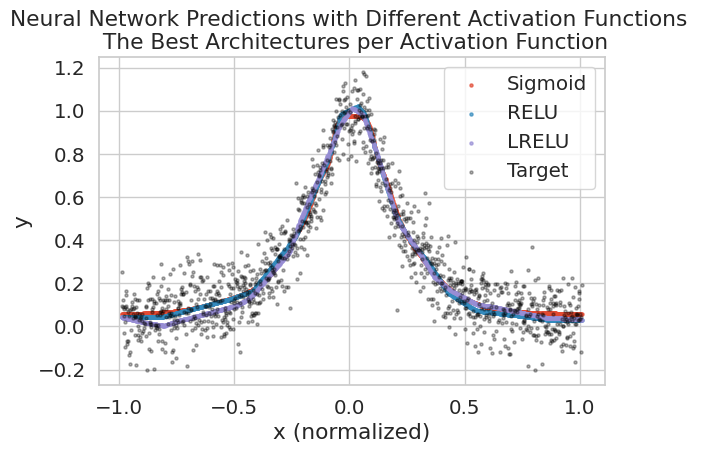

In [10]:
plt.scatter(X_train_norm, best_sigmoid_test["y_pred_train"], s=5, label="Sigmoid", alpha=0.7)
plt.scatter(X_train_norm, best_RELU_test["y_pred_train"], s=5, label="RELU", alpha=0.7)
plt.scatter(X_train_norm, best_LRELU_test["y_pred_train"], s=5, label="LRELU", alpha=0.7)
plt.scatter(X_train_norm, y_train, s=5, label="Target", alpha=0.3, color="black")
plt.xlabel("x (normalized)")
plt.ylabel("y")
plt.title("Neural Network Predictions with Different Activation Functions \n The Best Architectures per Activation Function")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(out_dir / f"d_best_act_preds_train.pdf", dpi=200, bbox_inches="tight")

### Part e) Testing different norms

**Task**: 
1) Find the optimal parameters for the neural network. Still using the **one-dimensional Runge function**, add now the hyperparameters $\lambda$ with the $L_2$ and $L_1$ norms.  Find the optimal results for the hyperparameters $\lambda$ and the learning rates $\eta$ and neural network architecture. 

2) Compare to project 1. Compare the $L_2$ results with **Ridge** regression from project 1 and the $L_1$ results with the **Lasso** calculations of project 1. Use again the same data sets and the best results from project 1 in your comparisons.

**Now we use the best architectures found from part d to assess the hyperparameters with added norms. The best architecture per activation function type is chosen as the option which yielded the lowest MSE on the test data.**

In [ ]:
best_architectures = {
    "sigmoid":  best_sigmoid_test["layers"],
    "RELU": best_RELU_test["layers"],
    "LRELU": best_LRELU_test["layers"]
}

activation_funcs = {
    "sigmoid": sigmoid,
    "RELU": RELU,
    "LRELU": LRELU
}

lambda_options = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
learning_rate_options = [0.001, 0.01, 0.1, 1.0, 1.01, 1.1, 1.5, 2.0]

**Using the best architectures, we now train the neural network with different options for hyperparameter $\lambda$ and different values for the learning rate $\eta$.**

In [12]:
results_reg = []

for act_name, layers in best_architectures.items():
    for reg_type in ["L1","L2"]:
        for lamb in lambda_options:
            for lr in learning_rate_options:
                activate = activation_funcs[act_name]
                
                activation_funcs_list = [activate]*len(layers) + [identity]
                activation_ders_list  = [derivate(activate) for _ in layers] + [derivate(identity)]
                
                nn = NeuralNetwork(
                    network_input_size=X_train.shape[1],
                    layer_output_sizes=layers + [1],
                    activation_funcs=activation_funcs_list,
                    activation_ders=activation_ders_list,
                    cost_fun=mse,
                    cost_der=mse_der,
                    lamb=lamb,
                    cost_fun_type=reg_type
                )

                nn.train_SGD(X_train_norm, y_train, epochs=number_of_epochs, learning_rate=lr, batch_size=batch_size, optimizer="Adam")

                y_pred_test = nn._feed_forward(X_test_norm)
                y_pred_train = nn._feed_forward(X_train_norm)
                
                results_reg.append({
                    "architecture": act_name,
                    "layers": layers,
                    "activation": act_name,
                    "reg_type": reg_type,
                    "lambda": lamb,
                    "learning_rate": lr,
                    "train_error": mse(y_pred_train, y_train),
                    "test_error": mse(y_pred_test, y_test)
                })

df_reg = pd.DataFrame(results_reg)

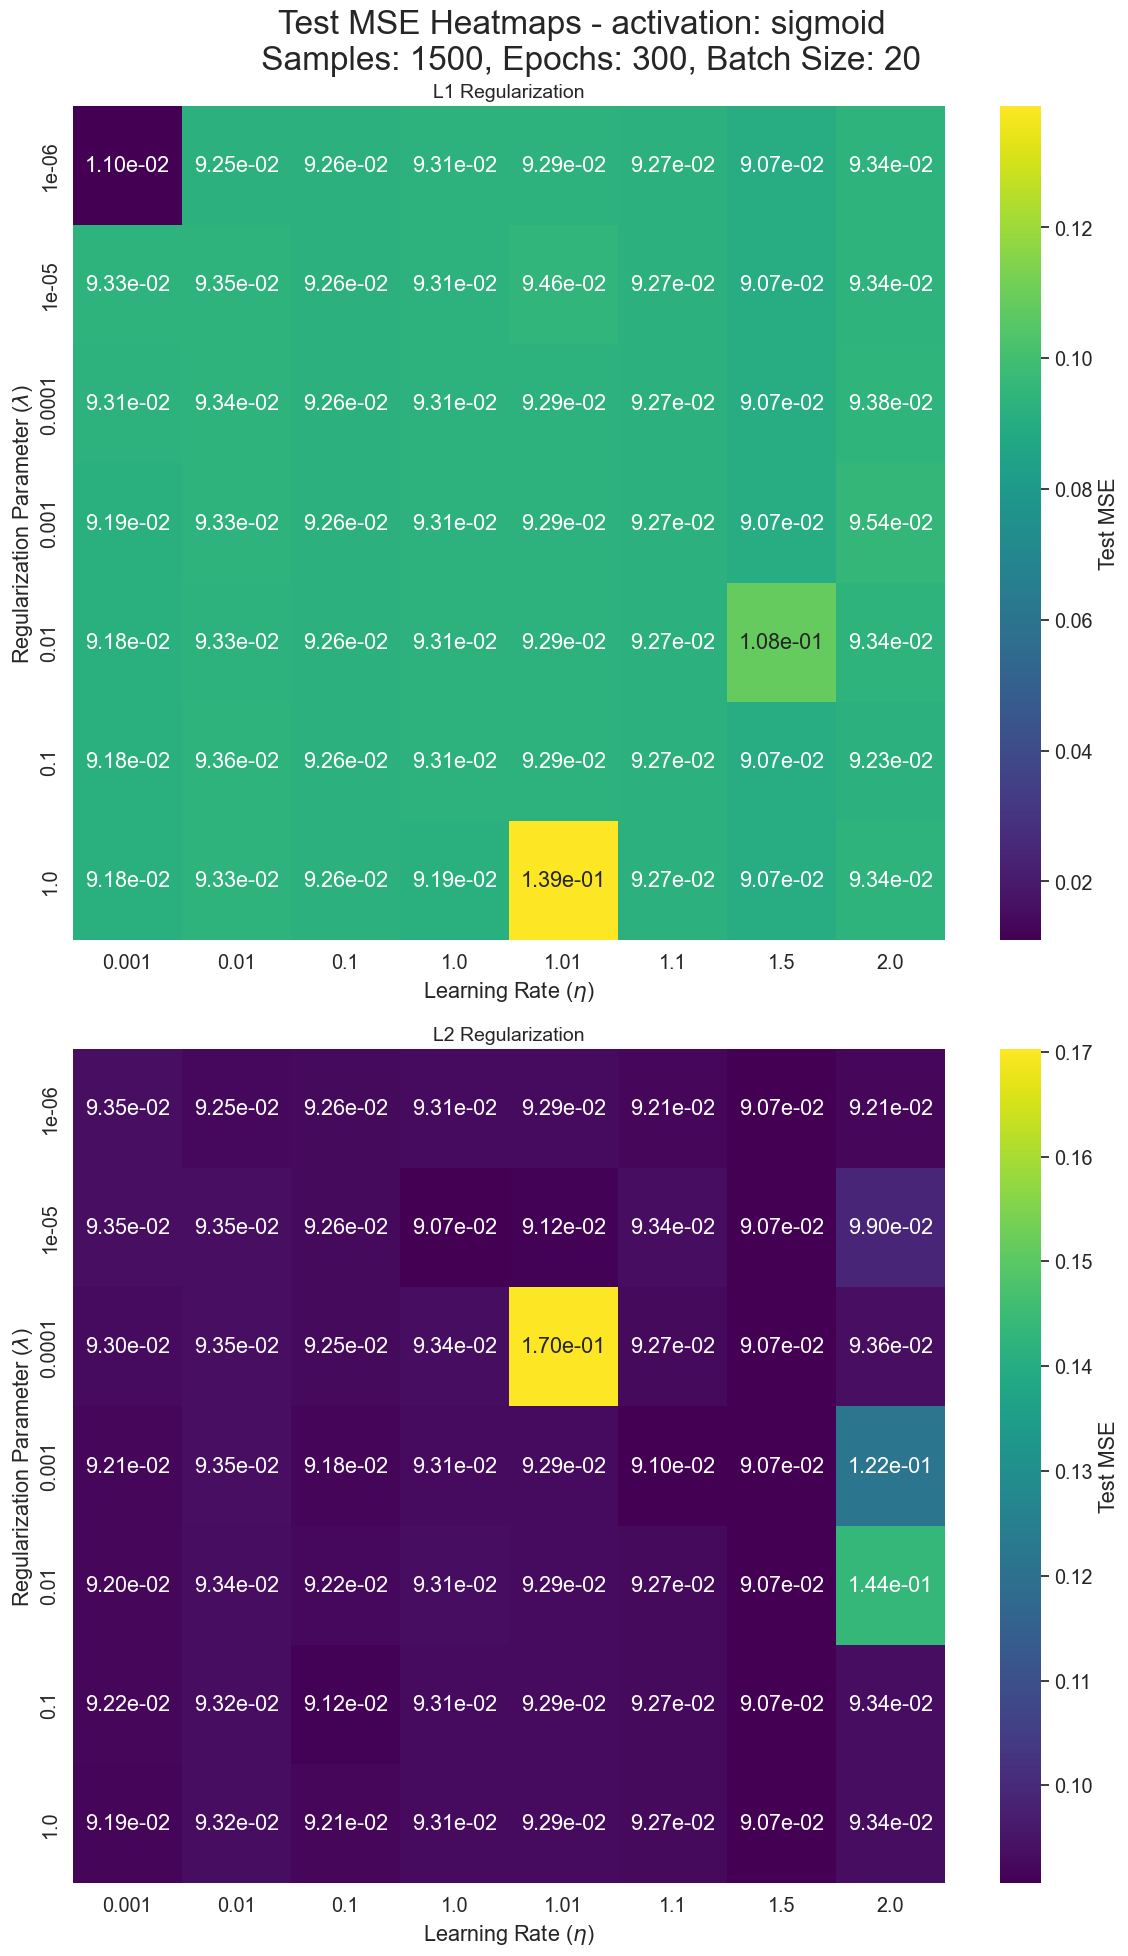

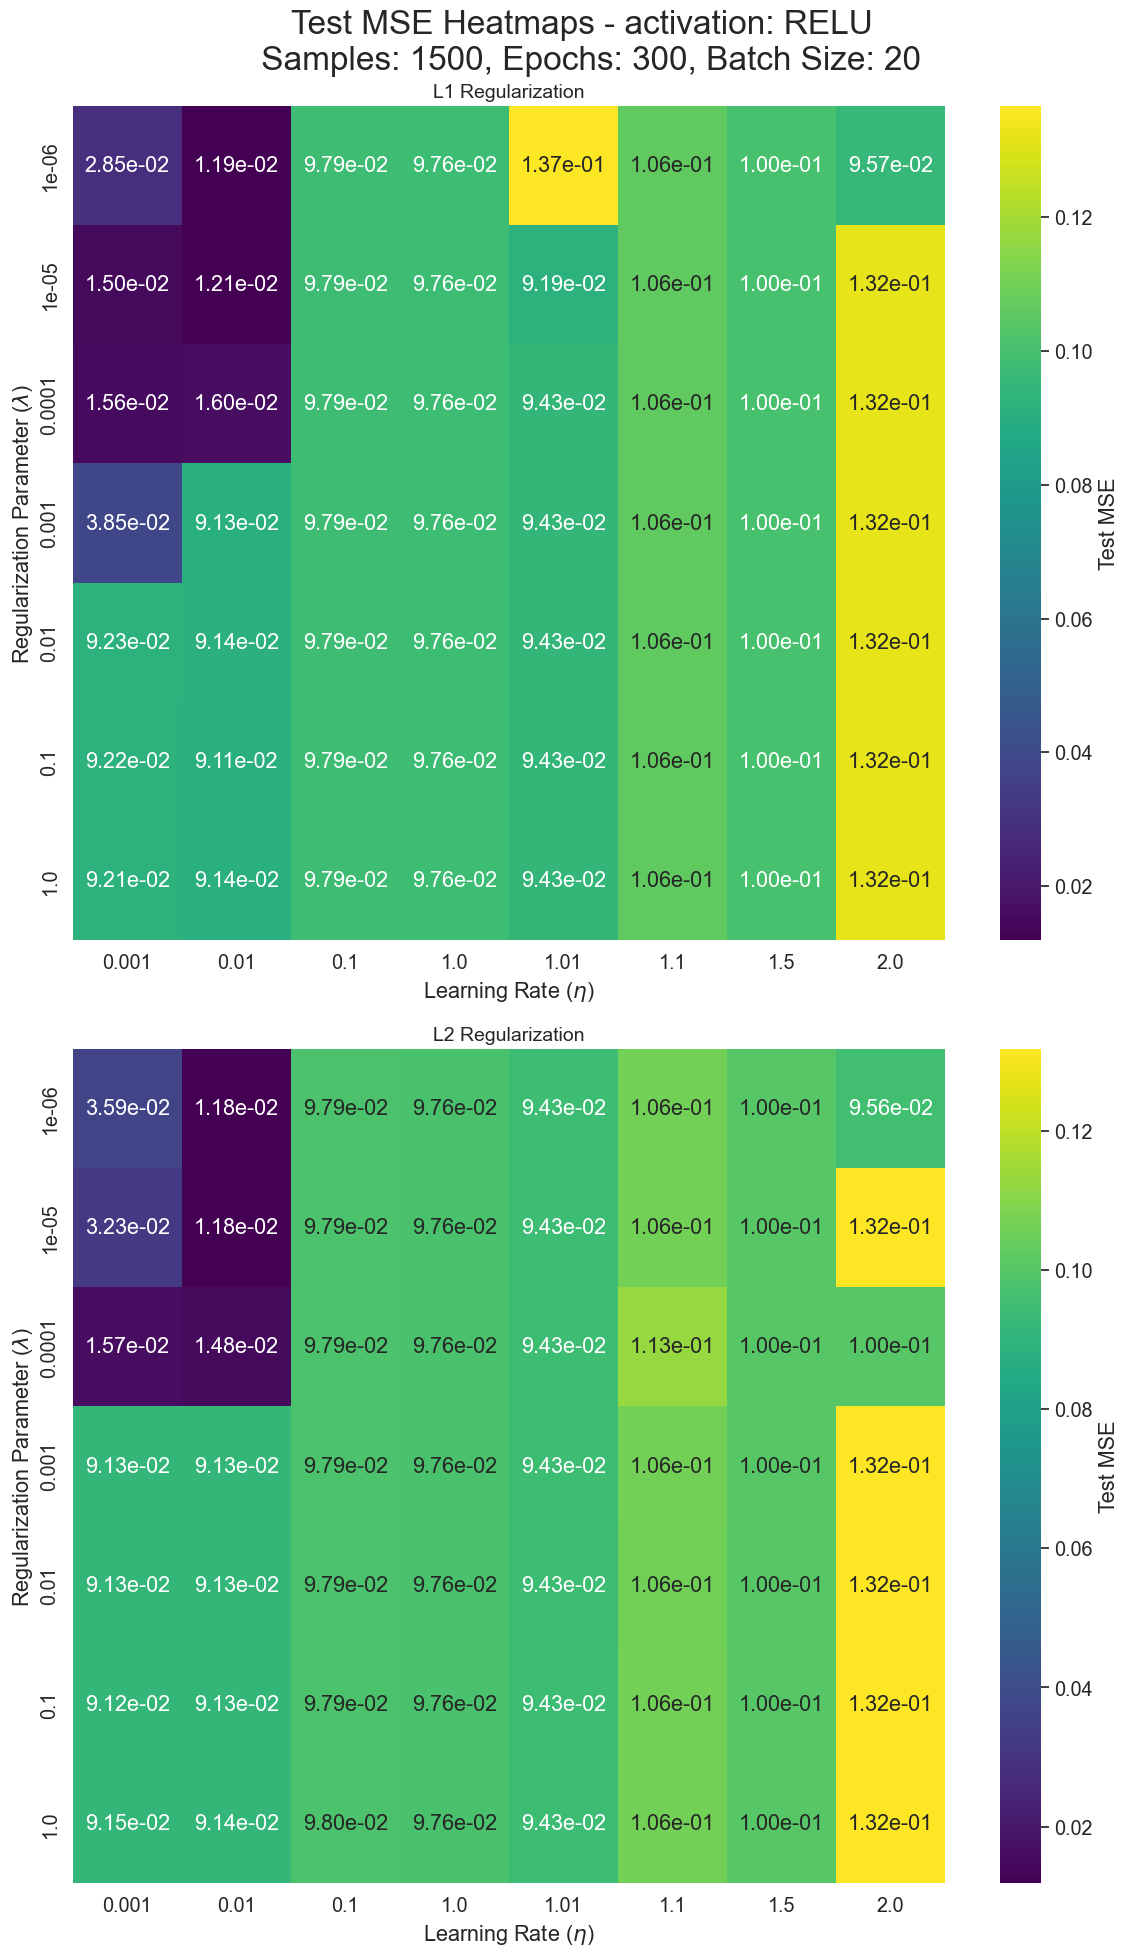

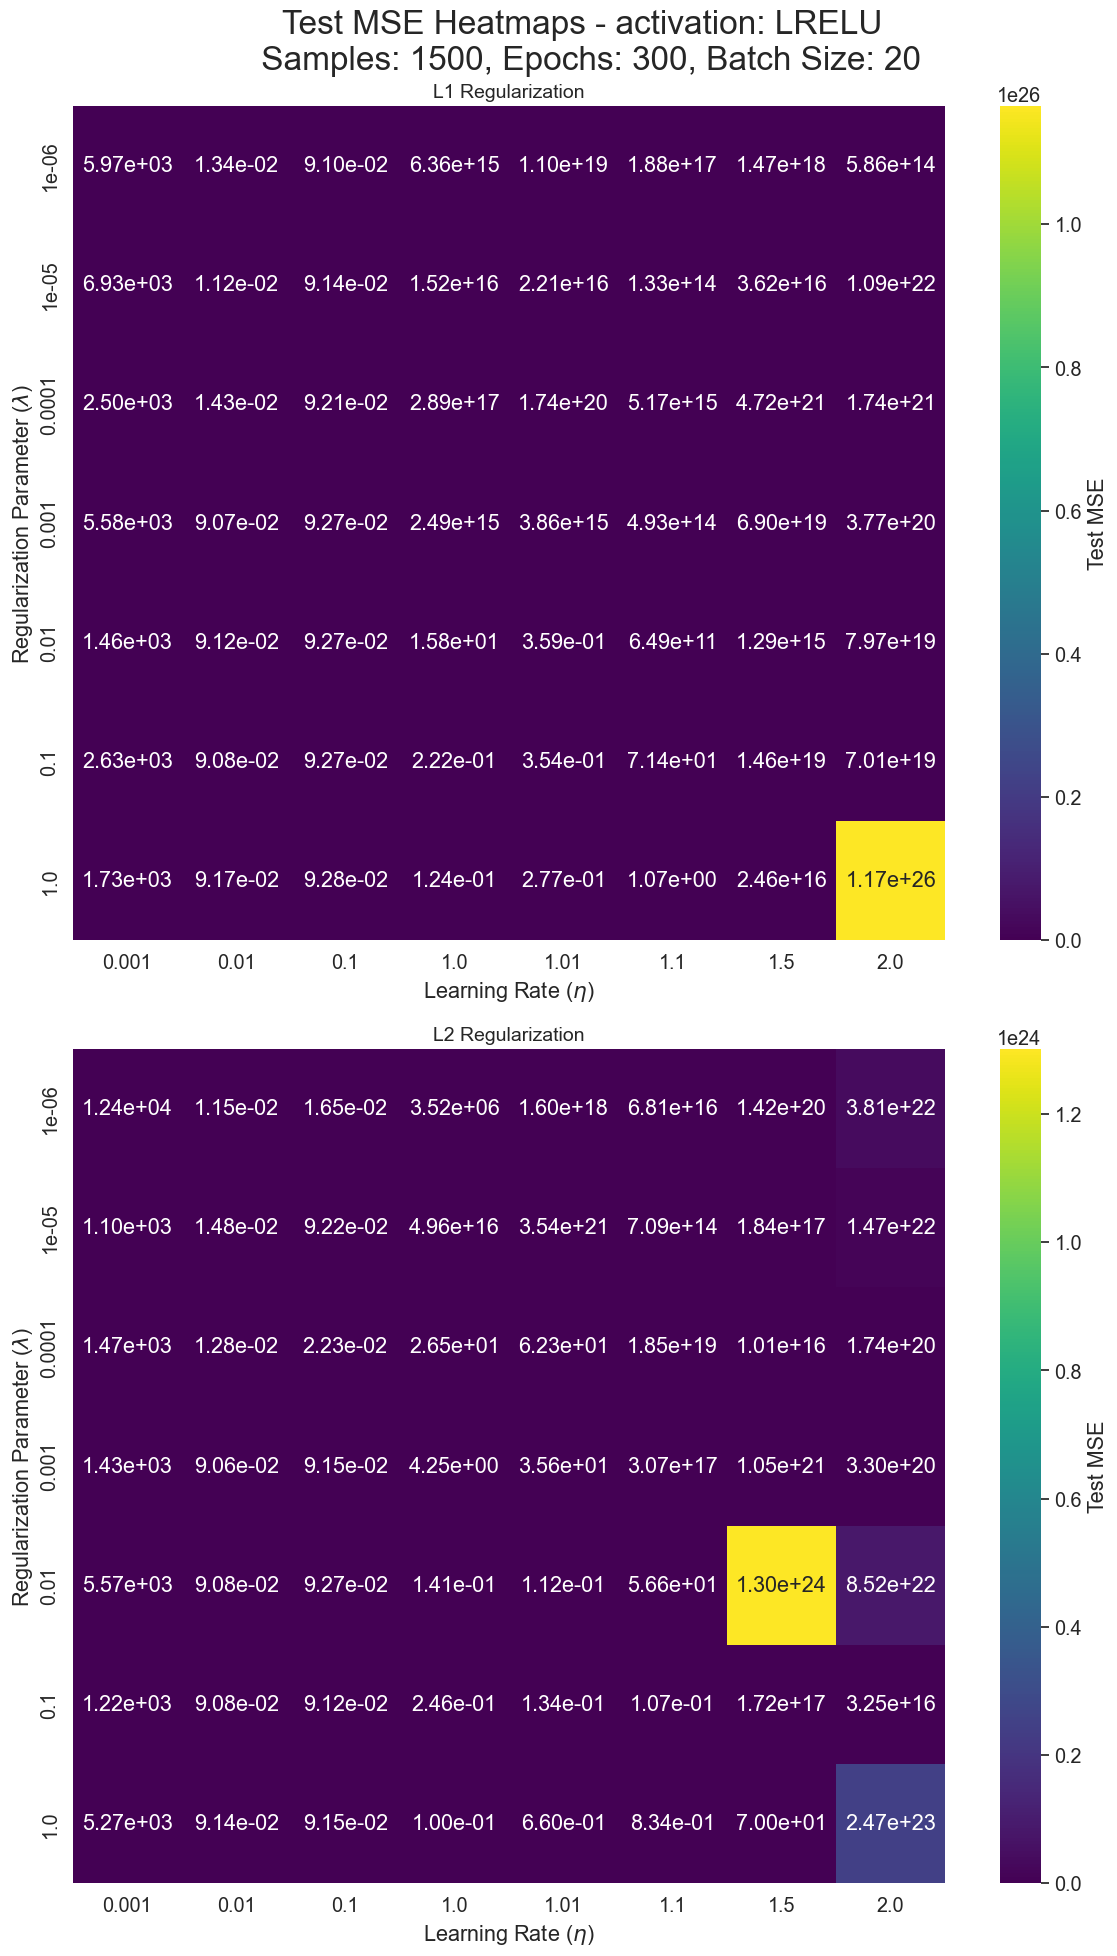

In [31]:
for arch in df_reg["architecture"].unique():
    fig, axes = plt.subplots(2, 1, figsize=(12, 20))
    
    for ax, reg_type in zip(axes, ["L1", "L2"]):
        df_plot = df_reg[
            (df_reg["architecture"] == arch) &
            (df_reg["reg_type"] == reg_type)
        ]
    
        heatmap_data = df_plot.pivot_table(
            index="lambda",
            columns="learning_rate",
            values="test_error",
            aggfunc="mean"
        )
        
        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt=".2e",
            cmap="viridis",
            cbar_kws={"label": "Test MSE"},
            ax=ax
        )
        
        ax.set_title(f"{reg_type} Regularization", fontsize=14)
        ax.set_xlabel(r"Learning Rate ($\eta$)")
        ax.set_ylabel(r"Regularization Parameter ($\lambda$)")

    fig.suptitle(f"Test MSE Heatmaps - activation: {arch} \n Samples: {n}, Epochs: {number_of_epochs}, Batch Size: {batch_size}")
    plt.tight_layout()
    fig.savefig(out_dir / f"e_NN_mse_lr_lmb_{arch}.pdf", dpi=200, bbox_inches="tight")

Above, we are training our neural network with stochastic gradient descent for updating the weights. We use 300 epochs and a batch size of 20 samples. Using the best architectures we found for the three evaluated activation functions, namely:

In [14]:
print("Best NN architectures for different activation functions:")
print("----------------------------------------------------------")
print("Sigmoid, assessed for MSE on the test data:", best_sigmoid_test)
print()
print("RELU, assessed for MSE on the test data:", best_RELU_test)
print()
print("LRELU, assessed for MSE on the test data:", best_LRELU_test)

Best NN architectures for different activation functions:
----------------------------------------------------------
Sigmoid, assessed for MSE on the test data: layers                                         [8, 8, 8, 8, 8, 8, 8]
activation                                                   sigmoid
y_pred_test        [[0.07704310183517171], [0.16736629268436976],...
y_pred_train       [[0.4439521892297576], [0.13207143831191448], ...
train_error                                                 0.009542
test_error                                                  0.010844
n_hidden_layers                                                    7
n_nodes                                                            8
Name: 132, dtype: object

RELU, assessed for MSE on the test data: layers                                      [16, 16, 16, 16, 16, 16]
activation                                                      RELU
y_pred_test        [[0.06934877352102553], [0.19994277925523712],...
y_pred_train 

Using these architectures, and applying both an L1 and L2 norm for different values of hyperparameter $\lambda$ and learning rate $\eta$, we find when testing for $\lambda = (10^{-6}, 10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 0.1, 1.0)$ and $\eta = (0.001, 0.01, 0.1, 1.0, 1.01, 1.1, 1.5, 2.0)$, **the best networks are:**

In [15]:
# Best network for each combination
best_L2 = df_reg[df_reg["reg_type"]=="L2"].sort_values("test_error").iloc[0]
best_L1 = df_reg[df_reg["reg_type"]=="L1"].sort_values("test_error").iloc[0]

print("Best L2 network:")
print(best_L2[["architecture", "layers", "lambda", "learning_rate", "train_error", "test_error"]])
print('-'*50)
print("Best L1 network:")
print(best_L1[["architecture", "layers", "lambda", "learning_rate", "train_error", "test_error"]])
print()
print('-'*50)
for act in df_reg["activation"].unique():
    df_act = df_reg[df_reg["activation"] == act]
    
    # Find the row with minimum test error
    best_row = df_act.loc[df_act["test_error"].idxmin()]
    
    print(f"Best network for activation: {act}")
    print(best_row[["reg_type", "layers", "lambda", "learning_rate", "train_error", "test_error"]])
    print("-"*50)

Best L2 network:
architecture                              LRELU
layers           [128, 128, 128, 128, 128, 128]
lambda                                 0.000001
learning_rate                              0.01
train_error                            0.010843
test_error                             0.011454
Name: 281, dtype: object
--------------------------------------------------
Best L1 network:
architecture                   sigmoid
layers           [8, 8, 8, 8, 8, 8, 8]
lambda                        0.000001
learning_rate                    0.001
train_error                   0.009981
test_error                    0.011023
Name: 0, dtype: object

--------------------------------------------------
Best network for activation: sigmoid
reg_type                            L1
layers           [8, 8, 8, 8, 8, 8, 8]
lambda                        0.000001
learning_rate                    0.001
train_error                   0.009981
test_error                    0.011023
Name: 0, dtype: object

### Comparison to results from project 1

##### Analytical Ridge regression
* First analysis was done for $n=700$ samples and $\lambda=0.1$. With those parameters, the best model degree was $p=8$ which had a test MSE of order $0.00014$. (Figure 18)
* We then varied the number of samples to see the impact of $n$ on MSE. For $p=8$ and $\lambda=0.1$, we found that the MSE decreased rapidly with number of samples. The Lowest MSE was found for $n=1910$. The MSE was then $0.000046$ (figure 19).
* Then, then Ridge regression was performed with $p=8$ and $n=1500$, with varying $\lambda$. The MSE was found to not change much, and stay low for hyperparameters smaller than $10^{-3}$. The MSE was then around $0.000045$ (figure 20).
* Lastly, Ridge regression was performed with $n=1500$ and $\lambda=10^{-3}$ (the best parameter combination found). The MSE of the prediction mad eon the test data was then $0.00005$ (figure 1).

##### Gradient descent methods on Ridge and Lasso
* $n=1500$, $p=14$, $\lambda=0.001$ for all GD experiments.
* Results from table 2:
    * Ridge - GD : 0.000113
    * Lasso - GD : 0.000111
    * Ridge - Momentum : 0.000090
    * Lasso - Momentum : 0.000083
    * Ridge - AgaGrad : 0.000153
    * Lasso - AgaGrad : 0.000152
    * Ridge - RMSProp : 0.000090
    * Lasso - RMSProp : 0.000075
    * Ridge - Adam : 0.000090
    * Lasso - Adam : 0.000075

##### Stochastic gradient descent on Ridge and Lasso
* 300 epochs and with a batch size of 20 samples
* Applying stochastic gradient descent to the previous gradient descent methods mentioned.
* The resulting MSEs lies in the ranges:
    * Ridge: 0.00009 - 0.0002
    * Lasso: 0.00008 - 0.0002

##### K-fold cross-validation on Ridge and Lasso
* $n=10000$
* The best model for Ridge regression using CV was found to be $p=12$, $\lambda=10^{-4}$ with an MSE of 0.0109.
* The best model for Lasso regression using CV was found to be $p=8$, $\lambda=10^{-4}$ with an MSE of 0.0143.

# Kjersti notat til skriving
* Hvis det ikke er "nok" noise i dataen, gir det ikke mening på bruke Lasso og Ridge. Med Lasso og Ridge kommer det et bias, noe OLS ikke har, så om det ikke er særlig med noise vil det være hensiktsmessig for Ridge og Lasso og "bli til OLS" med lambda lik null.
* Her ser vi likevel at det lønner seg med en liten lambda.
* Kan sammenligne med analytisk Ridge og basic Lasso, eller sammenligne med stochastic gradient descent. Gjør det som er mest interessant. 

Bare ta tallene fra CV og diskuter. 

* Sigmoid: tends to saturate (vanishing gradients), so performance often degreades with depth (number of hidden layers).
* ReLU: Usually performs best for deeper networks due to non-saturating gradient.
* Leaky ReLU: Often similar to ReLU but better for very deep networks (less dead neurons).

* Increasing nodes/layers usually improves training performance but may increase overfitting.

* Diskuter, 3-gradspolynom ville vi forvente at OLS er bedre. Men Runge er vanskelig å få til i endepunktene, så her er nok NN bedre enn OLS og andre klassiske regresjonsmetoder.
* Dette er universal approksimasjonsteoreom i praksis. Vi vet vi kan approksimere til en viss feil, med minst et lag. Diskusjon!

Sigmoid function, returns outputs between 0 and 1. 
* Useful for probabilisitic classification.
* Can be computationally costly.
* During training, the sigmoid function can cause gradients to become very small, which slows down learning, especially in deep networks.

ReLU (Rectified Linear Unit), returns the input it recieves if the value is positive. Returns zero otherwise.
* Fast to compute
* Introduces nonlinearity
* Mitigates vanishing gradient problem. If the input is positive, the gradient is a constant 1. Helps prevent gradients becoming too small during backpropagation and allows for faster learning.
* If a neuron consistently receives negative inputs, it can get stuck in a state where it always outputs zero. Because the gradient is also zero, its weights are never updated, and the neuron becomes inactive (dies).

LReLU (Leaky Rectified Linear Unit), also outputs the input if it is positive, but instead of zero for negative inputs it returns a small fraction. 
* Main purpose to prevent dying neurons.
* Leads to more stable and consistent training.